In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn import ensemble, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load dataset 
train = pd.read_csv('../input/train.csv')
weather = pd.read_csv('../input/weather.csv')

In [2]:
labels = train.WnvPresent.values

# Not using codesum for this benchmark
weather = weather.drop('CodeSum', axis=1)

# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

In [3]:
# Functions to extract month and day from dataset
# You can also use parse_dates of Pandas.
def create_year(x):
    return x.split('-')[0]

def create_month(x):
    return x.split('-')[1]

def create_day(x):
    return x.split('-')[2]

train['year'] = train.Date.apply(create_year)
train['month'] = train.Date.apply(create_month)
train['day'] = train.Date.apply(create_day)


# drop address columns
train = train.drop(['Address', 'AddressNumberAndStreet','WnvPresent'], axis = 1)

In [4]:
# Merge with weather data
train = train.merge(weather, on='Date')
train = train.drop(['Date'], axis = 1)

# Convert categorical data to numbers
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['Species'].values))
train['Species'] = lbl.transform(train['Species'].values)

lbl.fit(list(train['Street'].values)) 
train['Street'] = lbl.transform(train['Street'].values)

lbl.fit(list(train['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)

In [5]:
# drop columns with -1s
train = train.loc[:,(train != -1).any(axis=0)]

In [6]:
train = train.loc[:, ["Species", "Tmax_x", "PrecipTotal_x", "month", "day", "year", "NumMosquitos", 'Latitude', 'Longitude']]

## Train Test split based on year and train classifiers

In [7]:
preds = dict()
for year in set(train.year):
    X_train = train.loc[train.year.values != year] 
    X_test  = train.loc[train.year.values == year] 
    y_train = labels[train.year != year]
    y_test  = labels[train.year == year]
    X_train = X_train.drop(['year'], axis = 1)
    X_test = X_test.drop(['year'], axis = 1)
    clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=1000, min_samples_split=3)
    clf.fit(X_train, y_train)
    predictions = clf.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, predictions)
    preds[year] = (y_test, predictions, roc_auc)
    print "rf", year, roc_auc

rf 2009 0.709310833137
rf 2011 0.790009575767
rf 2007 0.76334538343
rf 2013 0.790672546044


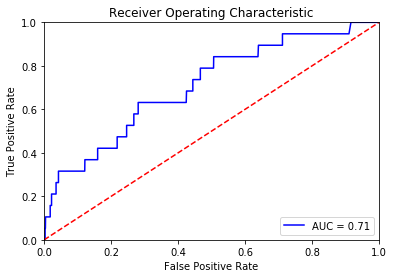

In [8]:
fpr, tpr, threshold = roc_curve(preds['2009'][0], preds['2009'][1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % preds['2009'][2])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [9]:
preds = dict()
for year in set(train.year):
    X_train = train.loc[train.year.values != year] 
    X_test  = train.loc[train.year.values == year] 
    y_train = labels[train.year != year]
    y_test  = labels[train.year == year]
    X_train = X_train.drop(['year'], axis = 1)
    X_test = X_test.drop(['year'], axis = 1)
    # Standarizing each column
    column_names = X_train.columns
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    X_train.columns = column_names
    X_test.columns = column_names
    # modeling with linear svm
    svm_model = SVC(kernel='linear', probability = True, random_state = 42)
    svm_model.fit(X_train, y_train)
    predictions = svm_model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, predictions)
    preds[year] = (y_test, predictions, roc_auc)
    print "linear svm", year, roc_auc

linear svm 2009 0.456761859806
linear svm 2011 0.577633994852
linear svm 2007 0.405414839398
linear svm 2013 0.433969726003


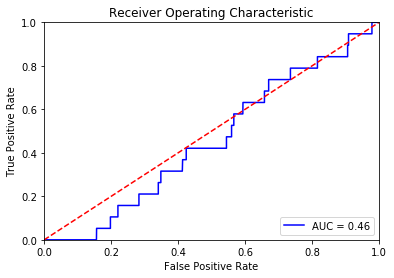

In [10]:
fpr, tpr, threshold = roc_curve(preds['2009'][0], preds['2009'][1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % preds['2009'][2])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()